In [2]:
from obspy.core import Stream, read
import numpy as np
from pytensor.compile.ops import as_op
import pytensor
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import pandas as pd
import os 
import os.path
import pymc as pm
import arviz as az

In [26]:
# What exactly are the colunns here? Amplitude of waves at a specific time?
# My equivalent = peak strain at a specific time

# Build the target function, misfit to this is what is being minimized
@as_op(itypes=[pt.dvector,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar,pt.dscalar], otypes=[pt.dvector]) # input variable types and output variable type(s)
def two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    y_out = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    y_out = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    # print(b2)
    
    # Make second straight line
    y_out[i] = m2*x[i] + b2

    return y_out

# Build the target function, misfit to this is what is being minimized
def non_pytensor_two_straight_lines(x,m1,m2,xinter,x0,y0):
    '''
    input x coordiantes are in x
    slopes are m1 and m2
    intercept of left hand line is b1 
    intersection of two lines is at xinter
    
    Note that y intercept of second straight line is dependent on b1 and xinter
      and defined entirely by them (so that the lines touch).
    '''
    
    # Output vector
    yout = np.ones(len(x))
    
    # Before building the first straight line, calculate the intercept
    b1 = y0 - m1*x0
    
    # Build first straight line segment
    yout = m1*x + b1
    
    # Find points that are after the intersection and make the second segment
    i = np.where(x>xinter)[0]
    
    # Define second y intercept
    b2 = m1*xinter + b1 - m2*xinter
    
    # Make second straight line
    yout[i] = m2*x[i] + b2

    return yout

In [27]:
path = '/Users/sydneydybing/StrainProject/2024/taiwan_strain_data/'
events = pd.read_csv(path + 'events_csv.csv')
snr_array = pd.read_csv(path + 'station_data_hypdists_snrs.csv')
snr_array

,Sta,Lat,Lon,Depth(m),2009_hyp_dist_km,2013_hyp_dist_km,2018_hyp_dist_km,snrs_2009,snrs_2013,snrs_2018
0,BCWB,24.2184,121.6891,-192,69.496535,74.182696,7.066640,-,-,-
1,TRKB,24.1614,121.6127,-192,61.088805,65.767547,9.697232,-,1152.20250487,3719.0718215
2,NTTB,24.1728,121.5259,-175,60.587926,65.180780,18.587874,-,-,-
3,SJNB,24.1073,121.6006,-193,54.988063,59.668808,12.226300,-,1534.07924347,130.500478359
4,HGSB,23.4903,121.4237,-266,15.739505,11.125139,79.319331,-,439.289654937,372.018353576
5,CHMB,23.4868,121.4703,-191,15.969342,11.924641,78.079695,-,348.253341927,40.3376474275
6,SSNB,23.4423,121.3981,-185,21.504342,16.833483,85.224271,-,766.890947625,129.005945014
7,ZANB,23.3947,121.4585,-218,26.068219,21.740867,88.175343,-,3295.27964074,106.461336916
8,FBRB,23.1406,121.2796,-200,56.994188,52.307853,120.756809,-,410.300738921,80.3548941939
9,SSTB,23.1340,121.3782,-199,55.447392,50.858196,118.191393,-,359.179515365,47.0870229521


In [107]:
events

,evt_id,origin_time,lat,lon,depth
0,2009-10-03_M6.1,2009-10-03T17:36:06.120,23.630,121.452,28.0
1,2013-10-31_M6.3,2013-10-31T12:02:08.720,23.590,121.437,10.0
2,2018-02-04_M6.1,2018-02-04T13:56:41.950,24.157,121.708,12.0


In [124]:
events_list = []
mags_list = []
stas_list = []
hypdist_list = []
xhighs_list = []
m1s_list = []
m2s_list = []
xinters_list = []
sigmas_list = []
trans_time_list = []

for ii in range(len(events)):
    
    evt_id = events['evt_id'][ii]
    print(evt_id)

    for idx in range(len(snr_array)):

        sta = snr_array['Sta'][idx]
        
        # Figure out the bounds for the MCMC based on the event and hypocentral distance (rainbow plots)
        xlow = 10
        
        if evt_id == '2009-10-03_M6.1':
            mag = '6.1'
            hypdist = snr_array['2009_hyp_dist_km'][idx]
        elif evt_id == '2013-10-31_M6.3':
            mag = '6.3'
            hypdist = snr_array['2013_hyp_dist_km'][idx]
            if sta == 'FBRB' or sta == 'SSTB' or sta == 'DONB':
                xhigh = 30
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'ZANB':
                xhigh = 20
            elif sta == 'TRKB' or sta == 'SJNB':
                xhigh = 25
            elif sta == 'SSNB':
                xhigh = 15
            else:
                print('2013 sta typo ' + str(sta))
        elif evt_id == '2018-02-04_M6.1':
            mag = '6.1'
            hypdist = snr_array['2018_hyp_dist_km'][idx]
            if sta == 'TRKB' or sta == 'SJNB':
                xhigh = 13
            elif sta == 'HGSB' or sta == 'CHMB' or sta == 'SSNB' or sta == 'ZANB':
                xhigh = 35
            elif sta == 'FBRB' or sta == 'SSTB':
                xhigh = 55
            else:
                print('2018 sta typo ' + str (sta))
        
        int_hypdist = int(hypdist)
        
        try:
            pst = read(path + 'filtered_abs_peak_post_p/' + evt_id + '/' + sta + '.mseed')
        except:
            print('Skipping ' + sta + ', no data')
            continue

        print('Processing ' + str(sta))
        
        times = pst[0].times()
        data = pst[0].data
        log10_data = np.log10(data)
        samp_rate = pst[0].stats.sampling_rate
        print(samp_rate)
        
        vec_start = int(xlow*samp_rate)
        vec_end = int(xhigh*samp_rate)

        # Split into x and y vectors
        xobserved = times[vec_start:vec_end]
        yobserved = log10_data[vec_start:vec_end]
        x0 = xobserved[0]
        y0 = yobserved[0]
        
        # in order to pass the x variable into the target function it needs to be 
        # converted to a Theano "shared" variable
        pt_xobserved = pytensor.shared(xobserved)
        pt_x0 = pytensor.shared(x0)
        pt_y0 = pytensor.shared(y0)
            
        # MCMC run parameters, these are good numbers for a "production" run. If you are
        # fooling arund these can be lower to iterate faster
        Nburn = 5000 # burn in samples that get discarded
        Nmcmc = 15000 # bump to at least 5-10k
        Nchains = 4
        Ncores = 1
        
        # Bounds for the prior distributions
        xinter_low = 10 ; xinter_high = 25 # location of the line slope change
        
        # Define the Bayesian model
        with pm.Model()as model:
            
            # Use normal distributions as priors
            m1 = pm.Normal('m1', mu = 0.5, sigma = 1)
            m2 = pm.Normal('m2', mu = -0.1, sigma = 5)
            xinter = pm.Uniform('xinter', lower = xinter_low, upper = xinter_high)
            sigma = pm.HalfCauchy('sigma', beta = 10, initval = 1)
        
            # This is the model
            likelihood = pm.Normal('y', mu = two_straight_lines(pt_xobserved,m1,m2,xinter,pt_x0,pt_y0),
                                    observed = yobserved, sigma = sigma)

            # NUTS sampler (default) is gradient based and won't work, use metropolis
            step = pm.Metropolis(scaling = 0.1)
            
            # This runs the mcmc sampler
            mcmc = pm.sample(Nmcmc, tune = Nburn, chains = Nchains, cores = Ncores, step = step)
        
        # Done, now is post-processing to get the data out of the sampler

        posterior = az.extract(mcmc)
        
        # Unwrap coeficients - WRITE LINES TO SAVE THE ARRAYS!!!
        m1_array = posterior.m1.values
        m1 = np.mean(m1_array)
        # print('m1 mean: ' + str(round(m1,2)))
        
        m2_array = posterior.m2.values
        m2 = np.mean(m2_array)
        # print('m2 mean: ' + str(round(m2,2)))
        
        xinter_array = posterior.xinter.values
        xinter = np.mean(xinter_array)
        # print('xinter Mean: ' + str(round(xinter,2)))
        
        sigma_array = posterior.sigma.values
        sigma = np.mean(sigma_array)

        # Lines!
        b1 = y0 - m1*x0
        b2 = m1*xinter + b1 - m2*xinter
        
        # Make plot to check stuff
        xpredicted = np.arange(xobserved.min(), xobserved.max()+0.1, 0.1)
        ypredicted = m1*xpredicted + b1
        i = np.where(xpredicted > xinter)[0]
        ypredicted[i] = m2*xpredicted[i] + b2
        
        # Get one-sigma region (need to obtain a ton of forward models and get stats)
        N = len(posterior.m1.values)
        
        yfit = np.zeros((len(xpredicted), N))
        for k in range(N):
            yfit[:,k] = non_pytensor_two_straight_lines(xpredicted,m1_array[k],m2_array[k],xinter_array[k],x0,y0)
        mu = yfit.mean(1)
        sig = yfit.std(1) * 1.95 #for 95% confidence
        mu_plus = mu + sig
        mu_minus = mu - sig
        
        # Least squares
        mls, bls = np.polyfit(xobserved, yobserved, 1)
        
        # Find the transition point in ypredicted
        diff = np.round(np.diff(ypredicted), decimals = 5)
        # print(diff)
        first_slope = diff[0]
        second_slope = diff[-1]
        trans_idx = np.where((diff != first_slope) & (diff != second_slope))[0][0] + 1
        
        # Get the transition point
        mcmc_trans_x = xpredicted[trans_idx] # Number
        mcmc_trans_y = ypredicted[trans_idx]
        
        # Append things
        events_list.append(evt_id)
        mags_list.append(mag)
        stas_list.append(sta)
        hypdist_list.append(int_hypdist)
        xhighs_list.append(xhigh)
        m1s_list.append(m1)
        m2s_list.append(m2)
        xinters_list.append(xinter)
        sigmas_list.append(sigma)
        trans_time_list.append(mcmc_trans_x)
        
        # Create folder for the event
        array_save_dir = path + 'mcmc_arrays/' + evt_id + '/' + sta + '/'
        if os.path.isdir(array_save_dir):
            pass
        else:
            os.makedirs(array_save_dir)

        np.save(array_save_dir + 'xobserved.npy', xobserved)
        np.save(array_save_dir + 'yobserved.npy', yobserved)
        np.save(array_save_dir + 'xpredicted.npy', xpredicted)
        np.save(array_save_dir + 'ypredicted.npy', ypredicted)
        np.save(array_save_dir + 'forward_mus.npy', mu)
        np.save(array_save_dir + 'foward_sigs.npy', sig)
        
        summary = az.summary(mcmc, fmt = 'wide')
        print(summary)
        summary.to_csv(array_save_dir + 'mcmc_summary.csv', index = False)
        
        # Folder for figures
        fig_save_dir = path + 'mcmc_plots/' + evt_id + '/'
        if os.path.isdir(fig_save_dir):
            pass
        else:
            os.makedirs(fig_save_dir)
        
        az.plot_trace(mcmc)
        # plt.show()
        plt.savefig(fig_save_dir + sta + '_stats_plots.png', format = 'PNG')
        plt.close()

        # Plot all solutions
        fig = plt.figure(dpi = 100)
        ax = fig.add_subplot(111)
        ax.set_title(str(sta))
        
        ax.plot(xobserved, yobserved, color = 'blue', label = 'Observed (log peak strain)')
        ax.plot(xpredicted, ypredicted, color = 'red', label = 'Predicted (MCMC)')
        # ax.plot(xpredicted, mu, color = 'green', linestyle = '--', label = 'yfit')
        # ax.plot(xpredicted, xpredicted * mls + bls, color = 'orange', label = 'np.polyfit least squares')
        ax.scatter(xpredicted[trans_idx], ypredicted[trans_idx], marker = 'o', color = 'black', label = 'Transition at ' + str(round(xpredicted[trans_idx],2)) + ' sec')
        # ax.scatter(closest_trans_x, closest_trans_y, marker = 'o', color = 'green', label = 'Adjusted transition at ' + str(round(closest_trans_x,2)) + ' sec')
        # ax2 = ax.twinx()
        # ax2.plot(xobserved, pythags_arr, color = 'violet')
        # ax2.axhline(closest_trans_x, color = 'violet', linestyle = '--')
        ax.fill_between(xpredicted, mu_plus, mu_minus, color = 'gray', alpha = 0.2, label = '95% confidence') # 95% confidence interval
        ax.set_xlabel('Time (s) - p-wave at 10s')
        ax.set_ylabel('log10 of peak strain')
        # ax.set_xlim(10,13)
        ax.legend()
        
        # plt.show()
            
        plt.savefig(fig_save_dir + sta + '.png', format = 'PNG')
        plt.close()

2009-10-03_M6.1
Skipping BCWB, no data
Skipping TRKB, no data
Skipping NTTB, no data
Skipping SJNB, no data
Skipping HGSB, no data
Skipping CHMB, no data
Skipping SSNB, no data
Skipping ZANB, no data
Skipping FBRB, no data
Skipping SSTB, no data
Skipping DONB, no data
2013-10-31_M6.3
2013 sta typo BCWB
Skipping BCWB, no data
Processing TRKB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 110 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.046  0.063   1.896    2.129      0.023    0.017       8.0   
m2       0.068  0.002   0.065    0.071      0.000    0.000      15.0   
xinter  11.325  0.049  11.263   11.442      0.018    0.013       8.0   
sigma    0.189  0.004   0.183    0.196      0.000    0.000     633.0   

        ess_tail  r_hat  
m1          29.0   1.46  
m2          45.0   1.19  
xinter      29.0   1.48  
sigma     2090.0   1.01  
2013 sta typo NTTB
Skipping NTTB, no data
Processing SJNB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 104 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       2.203  0.051   2.105    2.295      0.019    0.014       7.0   
m2       0.085  0.001   0.083    0.087      0.000    0.000      16.0   
xinter  11.182  0.032  11.131   11.248      0.012    0.009       7.0   
sigma    0.149  0.003   0.144    0.154      0.000    0.000    6100.0   

        ess_tail  r_hat  
m1          25.0   1.49  
m2          36.0   1.18  
xinter      26.0   1.52  
sigma    10088.0   1.00  
Processing HGSB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       6.259  0.648   5.375    7.542      0.314    0.240       5.0   
m2       0.084  0.002   0.081    0.088      0.001    0.000      10.0   
xinter  10.333  0.034  10.270   10.384      0.017    0.013       5.0   
sigma    0.123  0.003   0.118    0.129      0.001    0.000      26.0   

        ess_tail  r_hat  
m1          14.0   2.60  
m2          31.0   1.32  
xinter      14.0   2.58  
sigma       94.0   1.10  
Processing CHMB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 99 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      10.065  0.886   8.389   11.553      0.395    0.303       5.0   
m2       0.079  0.001   0.077    0.081      0.000    0.000      14.0   
xinter  10.193  0.019  10.166   10.230      0.008    0.006       5.0   
sigma    0.094  0.004   0.088    0.103      0.001    0.001       9.0   

        ess_tail  r_hat  
m1          31.0   2.35  
m2          86.0   1.21  
xinter      35.0   2.36  
sigma       44.0   1.35  
Processing SSNB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 97 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       7.843  1.408   6.924    8.687      0.461    0.368      10.0   
m2       0.295  0.460   0.221    0.237      0.085    0.061     118.0   
xinter  10.479  1.558  10.193   10.249      0.365    0.263      10.0   
sigma    0.118  0.120   0.087    0.106      0.031    0.022      22.0   

        ess_tail  r_hat  
m1          11.0   1.36  
m2          43.0   1.08  
xinter      11.0   1.37  
sigma       11.0   1.11  
Processing ZANB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1      16.394  2.362  12.271   20.184      1.102    0.850       5.0   
m2       0.064  0.002   0.061    0.068      0.001    0.000       7.0   
xinter  10.174  0.028  10.138   10.229      0.012    0.009       5.0   
sigma    0.103  0.015   0.084    0.134      0.006    0.005       5.0   

        ess_tail  r_hat  
m1          32.0   2.39  
m2          47.0   1.57  
xinter      32.0   2.39  
sigma       26.0   2.29  
Processing FBRB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 102 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.612  0.057   1.501    1.694      0.024    0.018       5.0   
m2       0.076  0.001   0.074    0.077      0.000    0.000       8.0   
xinter  11.237  0.052  11.169   11.344      0.022    0.017       5.0   
sigma    0.118  0.002   0.114    0.121      0.000    0.000      38.0   

        ess_tail  r_hat  
m1          23.0   1.97  
m2          30.0   1.44  
xinter      22.0   1.98  
sigma       66.0   1.07  
Processing SSTB
100.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       7.996  2.909   4.295   13.433      1.419    1.091       5.0   
m2       0.075  0.001   0.073    0.076      0.000    0.000       7.0   
xinter  10.309  0.108  10.159   10.509      0.050    0.038       5.0   
sigma    0.120  0.021   0.092    0.159      0.009    0.007       5.0   

        ess_tail  r_hat  
m1          12.0   2.64  
m2          14.0   1.59  
xinter      12.0   2.64  
sigma       20.0   2.43  
Processing DONB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.015  0.057   0.927    1.123      0.013    0.009      18.0   
m2       0.077  0.002   0.074    0.079      0.000    0.000     188.0   
xinter  11.443  0.095  11.275   11.604      0.021    0.015      19.0   
sigma    0.162  0.006   0.150    0.172      0.000    0.000   11244.0   

        ess_tail  r_hat  
m1          75.0   1.15  
m2         319.0   1.02  
xinter      65.0   1.15  
sigma    13997.0   1.00  
2018-02-04_M6.1
2018 sta typo BCWB
Skipping BCWB, no data
Processing TRKB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 91 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       5.782  0.723   4.116    7.050      0.124    0.089      33.0   
m2       0.602  0.044   0.520    0.686      0.003    0.002     314.0   
xinter  10.326  0.060  10.228   10.444      0.009    0.006      37.0   
sigma    0.212  0.026   0.167    0.261      0.002    0.002     138.0   

        ess_tail  r_hat  
m1         123.0   1.09  
m2         398.0   1.01  
xinter     127.0   1.09  
sigma      489.0   1.03  
2018 sta typo NTTB
Skipping NTTB, no data
Processing SJNB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 91 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.470  0.350   0.782    1.771      0.161    0.122       9.0   
m2       1.705  2.831   0.305    8.442      1.239    0.930      10.0   
xinter  12.616  3.964  10.527   21.888      1.704    1.276       9.0   
sigma    0.156  0.088   0.088    0.340      0.041    0.031       8.0   

        ess_tail  r_hat  
m1          25.0   1.40  
m2          14.0   1.42  
xinter      65.0   1.38  
sigma       25.0   1.39  
Processing HGSB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 95 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.926  0.182   1.578    2.209      0.078    0.059       6.0   
m2       0.042  0.002   0.039    0.045      0.001    0.000      10.0   
xinter  11.245  0.138  11.036   11.496      0.058    0.043       6.0   
sigma    0.184  0.006   0.172    0.195      0.001    0.000      86.0   

        ess_tail  r_hat  
m1          32.0   1.84  
m2          20.0   1.36  
xinter      30.0   1.88  
sigma      177.0   1.03  
Processing CHMB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.666  0.010   0.647    0.684      0.002    0.001      29.0   
m2       0.050  0.001   0.049    0.051      0.000    0.000      56.0   
xinter  12.202  0.040  12.128   12.276      0.007    0.005      30.0   
sigma    0.095  0.003   0.089    0.100      0.000    0.000   13193.0   

        ess_tail  r_hat  
m1         130.0   1.11  
m2          33.0   1.08  
xinter     140.0   1.10  
sigma    14272.0   1.00  
Processing SSNB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.352  0.084   1.211    1.521      0.033    0.025       6.0   
m2       0.055  0.001   0.052    0.056      0.000    0.000      27.0   
xinter  11.291  0.094  11.118   11.442      0.037    0.027       6.0   
sigma    0.148  0.005   0.139    0.157      0.000    0.000    1072.0   

        ess_tail  r_hat  
m1          15.0   1.65  
m2          58.0   1.11  
xinter      16.0   1.65  
sigma     5183.0   1.01  
Processing ZANB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 96 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.845  0.215   1.448    2.236      0.098    0.075       5.0   
m2       0.040  0.001   0.039    0.041      0.000    0.000       9.0   
xinter  10.822  0.103  10.637   11.023      0.046    0.035       5.0   
sigma    0.080  0.003   0.074    0.087      0.001    0.001      16.0   

        ess_tail  r_hat  
m1          18.0   2.33  
m2          28.0   1.40  
xinter      18.0   2.36  
sigma       51.0   1.17  
Processing FBRB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 105 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       1.702  0.296   1.234    2.202      0.142    0.109       5.0   
m2       0.025  0.001   0.023    0.027      0.000    0.000       6.0   
xinter  11.820  0.337  11.298   12.413      0.157    0.119       5.0   
sigma    0.168  0.010   0.153    0.189      0.004    0.003       6.0   

        ess_tail  r_hat  
m1          25.0   2.46  
m2          15.0   1.86  
xinter      25.0   2.46  
sigma       30.0   1.75  
Processing SSTB
20.0


Sequential sampling (4 chains in 1 job)
CompoundStep
>Metropolis: [m1]
>Metropolis: [m2]
>Metropolis: [xinter]
>Metropolis: [sigma]


Sampling 4 chains for 5_000 tune and 15_000 draw iterations (20_000 + 60_000 draws total) took 103 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


          mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
m1       0.715  0.106   0.553    0.891      0.051    0.039       5.0   
m2       0.018  0.001   0.017    0.019      0.000    0.000       6.0   
xinter  12.441  0.403  11.868   13.156      0.189    0.143       5.0   
sigma    0.106  0.005   0.097    0.116      0.002    0.002       7.0   

        ess_tail  r_hat  
m1          24.0   2.48  
m2          21.0   1.91  
xinter      25.0   2.47  
sigma       28.0   1.61  
2018 sta typo DONB
Skipping DONB, no data


In [125]:
mcmc_array = np.column_stack((np.array(events_list), np.array(mags_list), np.array(stas_list), np.array(hypdist_list),
                             np.array(xhighs_list), np.array(m1s_list), np.array(m2s_list), np.array(xinters_list),
                             np.array(sigmas_list), np.round(np.array(trans_time_list),2)))

np.save(path + 'mcmc_arrays/mcmc_colstack_array.npy', mcmc_array)

In [162]:
taiwan_mcmc_array = np.load(path + 'mcmc_arrays/mcmc_colstack_array.npy')
taiwan_mcmc_array.shape

# Columns:
# 0. Event name
# 1. Magnitude
# 2. Station name
# 3. Hypocentral distance (km)
# 4. xhigh
# 5. m1 slope
# 6. m2 slope
# 7. intersection point
# 8. sigma
# 9. transition time

(17, 10)

In [166]:
na_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/filtered_mcmc_arrays/summary_array.npy')
na_mcmc_array.shape

(211, 10)

In [167]:
tohoku = pd.read_csv('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/stations_hypdists_snrs_flatsecs.list')
# tohoku
tohoku_mcmc_array = np.load('/Users/sydneydybing/StrainProject/2024/tohoku_strain_data/mcmc_arrays/mcmc_colstack_array.npy')
tohoku_mcmc_array.shape

(8, 10)

In [168]:
# Calculate earthquake source durations

# Get M0 from Mw, then use relation in Melgar and Hayes, 2017 to get duration

mags_for_relation = np.arange(6,9.25,0.25)
# print(mags_for_dur)

# Preferred params for source duration
apref_sd = -6.407
bpref_sd = 0.385

apref_rt = -5.323
bpref_rt = 0.293

source_durs = []
rise_times = []

for Mw in mags_for_relation:
    
    M0 = 10**(1.5*Mw + 9.05)
    # print(M0)
    
    log_sd = apref_sd + bpref_sd * np.log10(M0)
    source_dur = 10**log_sd
    source_durs.append(source_dur)
    
    log_rt = apref_rt + bpref_rt * np.log10(M0)
    rise_time = 10**log_rt
    rise_times.append(rise_time)
    

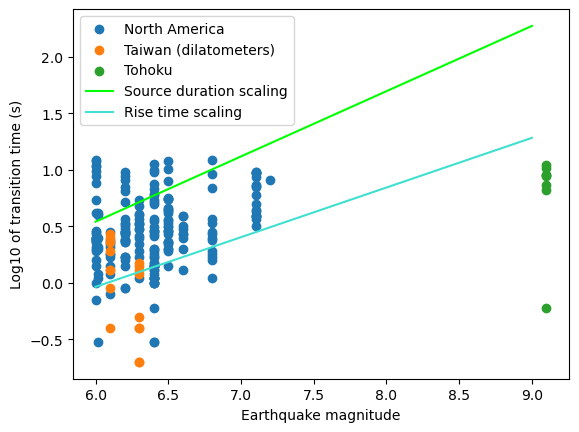

In [169]:
plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
plt.legend(loc = 'upper left');

In [170]:
# Get mean transition time by event

# North America

na_unique_eventids = np.unique(na_mcmc_array[:,0])

na_mags = []
na_mean_trans_times = []

for uni_id in na_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == na_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = na_mcmc_array[i,9].astype(float)-10
    mag = na_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    na_mags.append(mag)
    na_mean_trans_times.append(mean_trans_time)
    
na_mags = np.array(na_mags)
na_mean_trans_times = np.array(na_mean_trans_times)

# Taiwan

taiwan_unique_eventids = np.unique(taiwan_mcmc_array[:,0])

taiwan_mags = []
taiwan_mean_trans_times = []

for uni_id in taiwan_unique_eventids:
    
    print(uni_id)
    i = np.where(uni_id == taiwan_mcmc_array[:,0])[0]
    # print(i)
    
    trans_times = taiwan_mcmc_array[i,9].astype(float)-10
    mag = taiwan_mcmc_array[i,1].astype(float)[0]
    # print(mags)
    print(trans_times)
    
    mean_trans_time = np.mean(trans_times)
    # print(mean_trans_time)
    
    taiwan_mags.append(mag)
    taiwan_mean_trans_times.append(mean_trans_time)
    
taiwan_mags = np.array(taiwan_mags)
taiwan_mean_trans_times = np.array(taiwan_mean_trans_times)

# Tohoku

tohoku_mags = 9.1
tohoku_mean_trans_times = np.mean(taiwan_mcmc_array[:,9].astype(float)-10)

2010-01-10_M6.5
[4.3 2.3 3.1 2.2 5.5 2.  1.4]
2010-04-04_M7.2
[8.2]
2011-09-09_M6.4
[2.9 1.8 1.7 1.7 1.  1.5 1.1 1.2 1.4 1.  1.4 2.9 1.5 2.  1.1 1.4 2.6 1.4
 1. ]
2012-04-11_M6
[1.9 2.3 2.4 2.5 2.3 2.5 2.7 2.5 1.4 2.  2.9 2.4 0.7 2.8]
2012-11-08_M6.1
[2.1 2.8 1.7 0.8 2.4 1.2 1.8 1.4 1.8 2.3]
2012-12-14_M6.3
[3.7 2.6 4.  1.1 3.3]
2013-09-03_M6.1
[2.2]
2014-03-10_M6.8
[2.8 2.7 1.9 3.7 2.5 1.6 3.4 6.9 1.8 1.1 2.4 1.7]
2014-04-24_M6.5
[3.6 2.  2.9 3.2 1.9 2.7 2.9 2.9 2.3 2.3 3.6]
2014-08-24_M6.02
[1.1 2.  1.2 2.5 2.1 4.2 4.  0.3]
2016-12-08_M6.6
[2.7 2.5 3.9 2.7 2.  3.  3.2 3.9 1.3]
2018-08-22_M6.2
[3.  2.8 2.8 2.7 1.7 2.3 2.8 2.4 2.3 2.4 3.3 3.7]
2018-10-22T05_M6.5
[5.6 4.5 5.5 4.4 4.2 4.6]
2018-10-22_M6.8
[12.2  9.2]
2019-07-04_M6.2
[2.4 2.8]
2019-07-04_M6.4
[ 0.3  9.6  5.2  3.5  0.3  5.   9.9  7.5  6.8 11.3  6.1  6.   5.4  1.1
  1.4  1.1  1.3]
2019-07-06_M7.1
[4.4 7.4 7.2 3.9 3.9 4.3 9.4 3.2 6.  9.5 9.4 9.4 5.  8.7 9.6 3.9 7.  3.7
 3.9]
2019-08-29_M6.3
[2.2 3.4 3.3 4.1 1.9 4.8 3.  2.5 3

In [ ]:
m, b = np.polyfit(mags, np.log10(mean_trans_times), 1)
ma, ba = np.polyfit(mcmc_array[:,1].astype(float), np.log10(mcmc_array[:,9].astype(float)-10), 1)

NameError: name 'mags' is not defined

Text(0, 0.5, 'Log10 of transition time (s)')

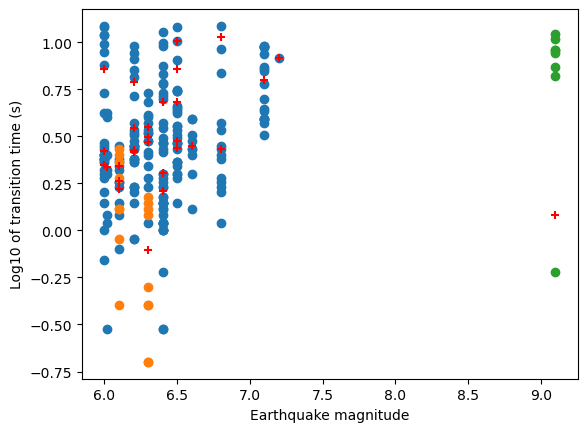

In [174]:
# plt.scatter(mcmc_array[:,3].astype(float), mcmc_array[:,9].astype(float)-10)
# plt.xlabel('Hypocentral distance (km)')
# plt.ylabel('Transition time (s)')
# plt.show()

plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10), label = 'North America')
plt.scatter(taiwan_mcmc_array[:,1].astype(float), np.log10(taiwan_mcmc_array[:,9].astype(float)-10), label = 'Taiwan (dilatometers)')
plt.scatter(tohoku_mcmc_array[:,1].astype(float), np.log10(tohoku_mcmc_array[:,9].astype(float)-10), label = 'Tohoku')
plt.scatter(na_mags, np.log10(na_mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
plt.scatter(taiwan_mags, np.log10(taiwan_mean_trans_times), marker = '+', color = 'red')
plt.scatter(tohoku_mags, np.log10(tohoku_mean_trans_times), marker = '+', color = 'red')
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
plt.xlabel('Earthquake magnitude')
plt.ylabel('Log10 of transition time (s)')
# plt.legend(loc = 'upper left');

# plt.scatter(na_mcmc_array[:,1].astype(float), np.log10(na_mcmc_array[:,9].astype(float)-10))
# plt.scatter(mags, np.log10(mean_trans_times), marker = '+', color = 'red', label = 'Mean transition time by event')
# # plt.plot(mags, mags * m + b, color = 'red', lw = 1)
# plt.plot(mcmc_array[:,1].astype(float), mcmc_array[:,1].astype(float) * ma + ba, color = 'C0', lw = 1)
# plt.plot(mags_for_relation, np.log10(source_durs), color = 'lime', label = 'Source duration scaling')
# plt.plot(mags_for_relation, np.log10(rise_times), color = 'turquoise', label = 'Rise time scaling')
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Log10 of transition time (s)')
# # plt.semilogy()
# plt.legend()
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,5].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 1 slope')
# plt.show()

# plt.scatter(mcmc_array[:,1].astype(float), mcmc_array[:,6].astype(float))
# plt.xlabel('Earthquake magnitude')
# plt.ylabel('Line 2 slope')
# plt.show()

In [163]:
pd_mcmc = pd.DataFrame(taiwan_mcmc_array, columns = ['eq_id', 'mag', 'sta', 'hypdist', 'xhigh', 'm1', 'm2', 'xinter', 'sigma', 'trans_time'])
pd_mcmc.to_csv(path + 'mcmc_arrays/mcmc_results_summary.csv', index = False)

In [164]:
# Figure out the "good" and "bad" performing waveforms using an L2 norm

mcmc_results = pd.read_csv(path + 'mcmc_arrays/mcmc_results_summary.csv')
mcmc_results

,eq_id,mag,sta,hypdist,xhigh,m1,m2,xinter,sigma,trans_time
0,2013-10-31_M6.3,6.3,TRKB,65,25,2.046405,0.068480,11.324532,0.189321,11.4
1,2013-10-31_M6.3,6.3,SJNB,59,25,2.202715,0.085420,11.181835,0.148766,11.2
2,2013-10-31_M6.3,6.3,HGSB,11,20,6.258803,0.084021,10.333483,0.123332,10.4
3,2013-10-31_M6.3,6.3,CHMB,11,20,10.064910,0.078963,10.193163,0.094482,10.2
4,2013-10-31_M6.3,6.3,SSNB,16,15,7.843087,0.294616,10.479085,0.118241,10.5
5,2013-10-31_M6.3,6.3,ZANB,21,20,16.394358,0.064127,10.174274,0.103334,10.2
6,2013-10-31_M6.3,6.3,FBRB,52,30,1.611918,0.075873,11.237477,0.117523,11.3
7,2013-10-31_M6.3,6.3,SSTB,50,30,7.996434,0.074661,10.309382,0.119741,10.4
8,2013-10-31_M6.3,6.3,DONB,67,30,1.015153,0.076568,11.443177,0.161560,11.5
9,2018-02-04_M6.1,6.1,TRKB,9,13,5.781758,0.602294,10.326080,0.211672,10.4
